In [ ]:
'''

Gene expression deconvolution and single cell sequencing analysis.

Jan 2022
Created by   Maral Dicle Maral
             Görkem Durmaz
             Ezgi Taş 
             
Analyzes the raw single cell count matrix, performs qc checks, 
normalizes the counts, performs PCA for dimensionality reduction,
performs leiden and louvain clustering with various neighborhood
and PC parameters, visualizes the final clusters, visualizes the human
annotated data, visualizes the target genes (differentially expressed OR genes)

Differentially expressed OR genes are determined by an Bulk RNA Differential 
Expreesion Experiment in Arzu Celik's laboratory by Ibrahim Ihsan Taskiran.

To run the code please visit the colab link (libraries are problematic to install to offline):

https://colab.research.google.com/drive/1AMDvaod95TbD2JD4DI4xUUXHhNlNfuCm?usp=sharing


'''

In [ ]:
 pip install scanpy==1.4.1 

In [ ]:
pip install loompy

In [ ]:
pip install numpy==1.19.5

In [ ]:
pip install pandas

In [ ]:
pip install anndata

In [ ]:
# Import and install scvi-tools in google colab
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-tools[tutorials]
    !pip install --quiet gdown
    !pip install --quiet --upgrade seaborn==0.10
    !pip install --quiet bbknn
  

In [ ]:
pip install scvi-tools

In [ ]:
pip install louvain

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from collections.abc import Mapping, Sequence
import h5py
import loompy as lp
import anndata
import scvi
import scanpy.external as sce

In [ ]:
# Downloads the data from drive file
!gdown 'https://drive.google.com/u/0/uc?id=1Inox_YFH85ZXELpcKpXrZuxQJHBb5bj5&export=download'
!unzip 'NEW_antenna.h5ad'
#!unzip r_fca_biohub_antenna_10x.loom.zip && rm r_fca_biohub_antenna_10x.loom.zip

In [ ]:
adata = anndata.read_h5ad("NEW_antenna.h5ad")

In [ ]:
scvi.model.SCVI.setup_anndata(adata)#scvi.data.setup_anndata(adata)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 37840 cells, 13077 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


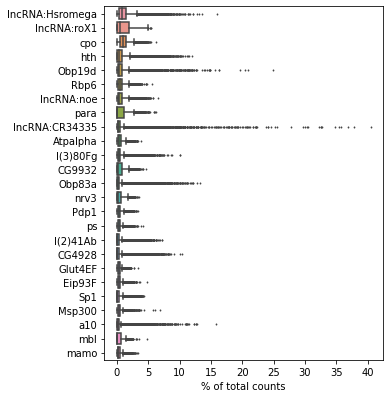

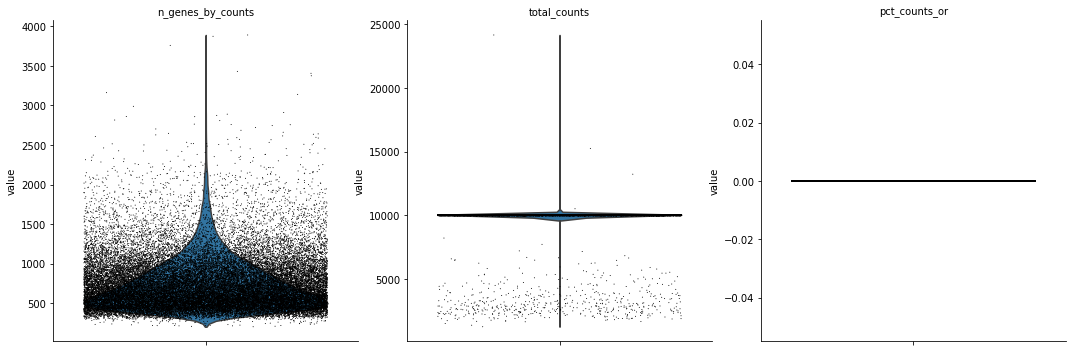

In [ ]:
# Genes that yield the highest fraction of counts in each single cell, across all cells
# Highly expressed genes across all cell types
sc.pl.highest_expr_genes(adata, n_top=25, )

# Filter genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the OR genes
adata.var['or'] = adata.var_names.str.startswith('OR-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['or'], percent_top=None, inplace=True) # log1p=False)

# Density estimator: # of genes by counts of genes, #of counts, #percent of or genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_or'], jitter=0.4, multi_panel=True)


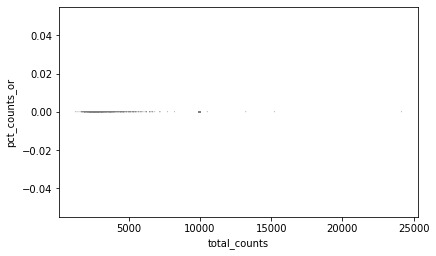

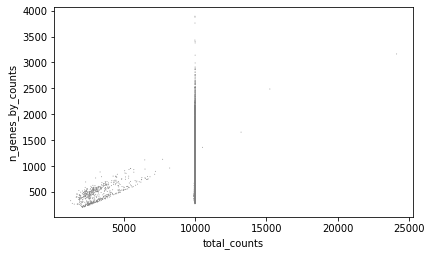

In [ ]:
# Removes cells that have too many or genes expressed or too many total counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_or')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
# More filtering
adata = adata[adata.obs.n_genes_by_counts < 2500, :] #excludes doublets from the data
adata = adata[adata.obs.pct_counts_or < 5, :] #excludes low quality cells in terms of their or expression

In [ ]:
# Normalizes counts by cell
sc.pp.normalize_total(adata, target_sum=1e4)
# Log normalization
sc.pp.log1p(adata)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


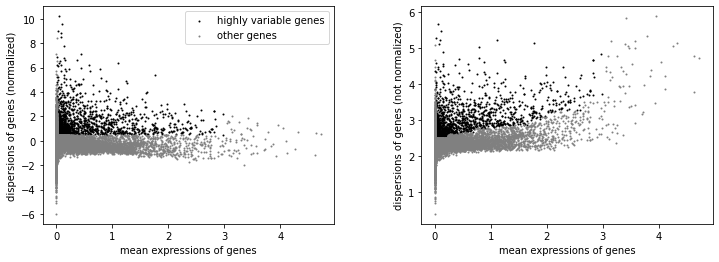

In [ ]:
# Extracts highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Normalized vs not normalized
sc.pl.highly_variable_genes(adata)

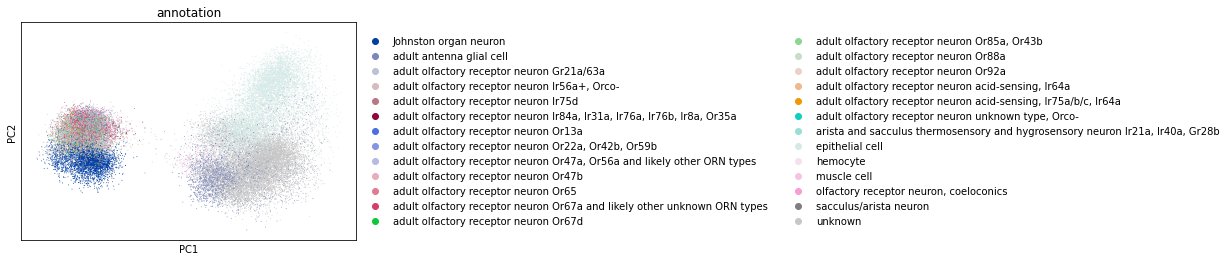

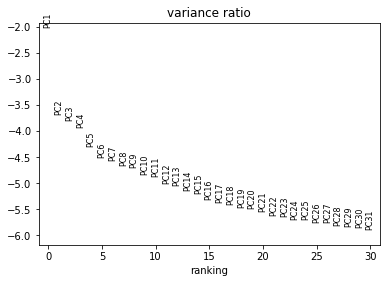

In [ ]:
# Dimensionality reduction with PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color=['annotation'])

# Plots highly variable genes in principle components
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
pip install numpy==1.19.5

In [ ]:
# Computes the neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=31, metric='correlation') #correlation
# Different parameters are tried for clustering:

#sc.pp.neighbors(adata, n_neighbors=15, n_pcs=31)
#sc.pp.neighbors(adata, n_neighbors=15)
#sc.pp.neighbors(adata, n_neighbors=10, n_pcs=31)

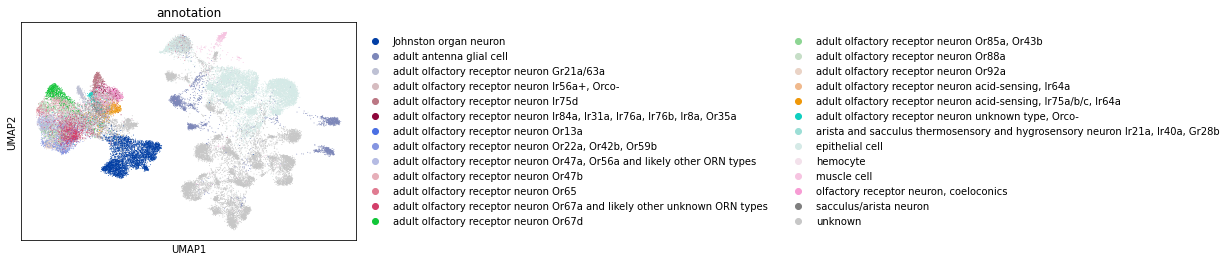

In [ ]:
# Sets up the umap
sc.tl.umap(adata)

# Plots the human annotated data
sc.pl.umap(adata, color=['annotation'])

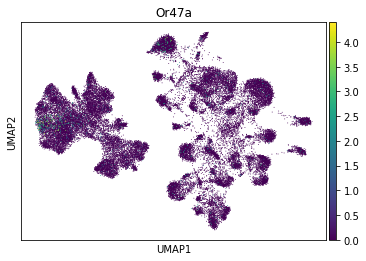

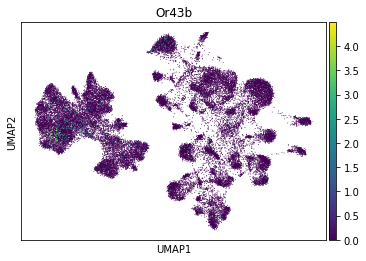

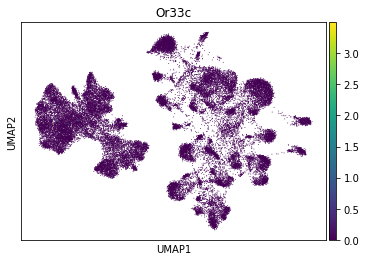

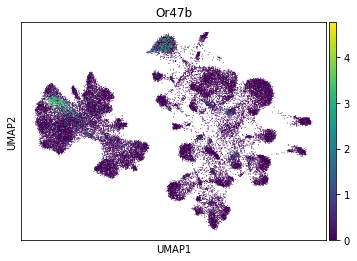

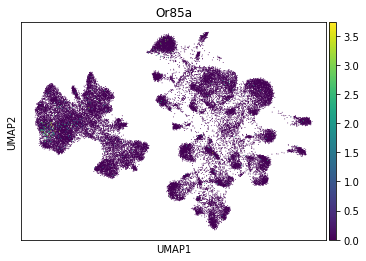

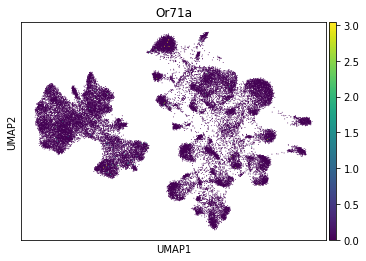

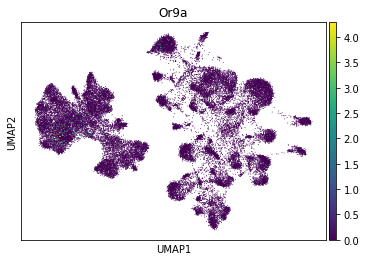

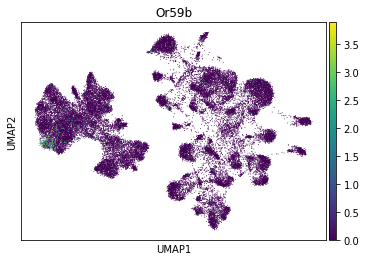

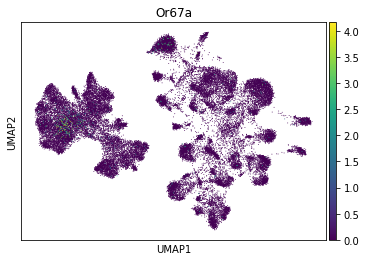

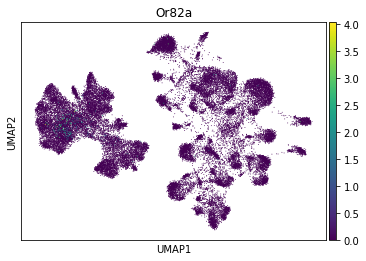

In [ ]:
# Clustering with leiden
sc.tl.leiden(adata)

list_diff_exp = ['Or47a', 'Or43b', 'Or33c', 'Or47b',  'Or85a', 'Or71a', 'Or9a', 'Or59b', 'Or67a', 'Or82a']
for gene in list_diff_exp:
  sc.pl.umap(adata, color=[gene])


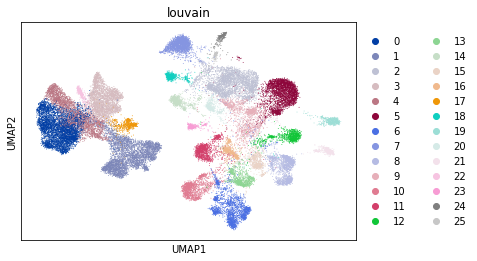

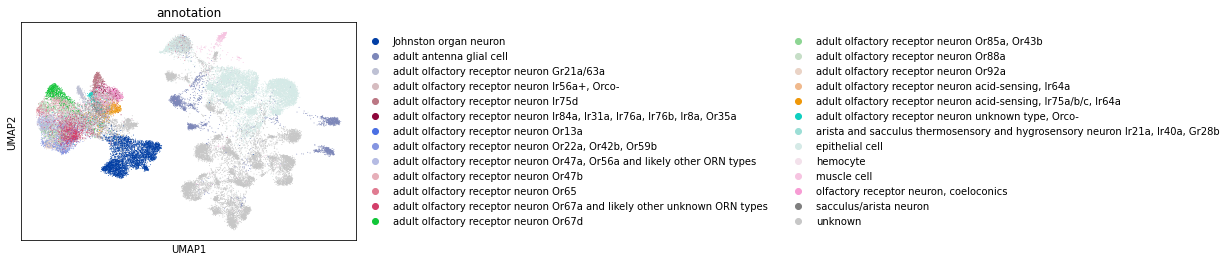

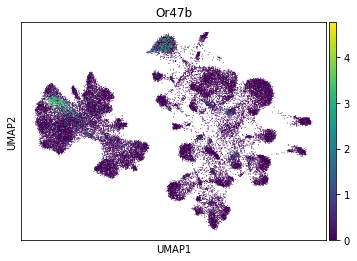

In [ ]:
# Clustering with louvain
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])
sc.pl.umap(adata, color=['annotation'])
sc.pl.umap(adata, color=['Or47b'])

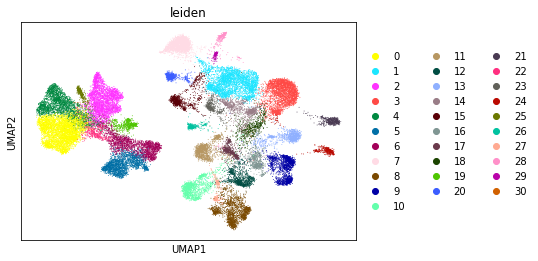

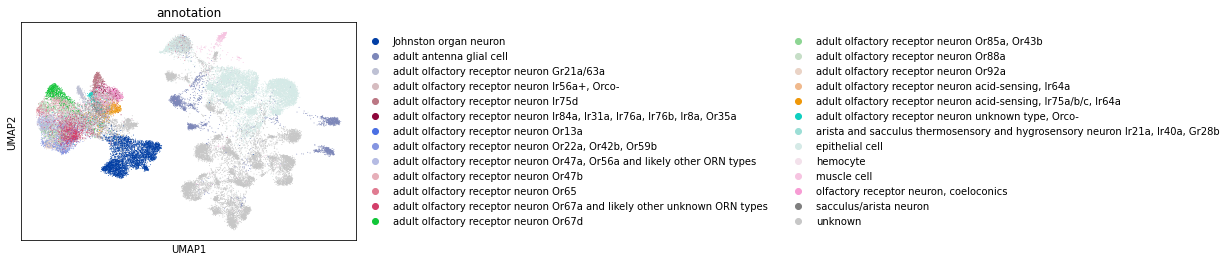

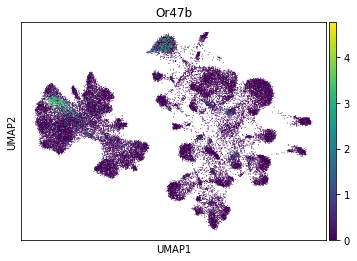

In [ ]:
# Clustering with leiden
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['annotation'])
sc.pl.umap(adata, color=['Or47b'])

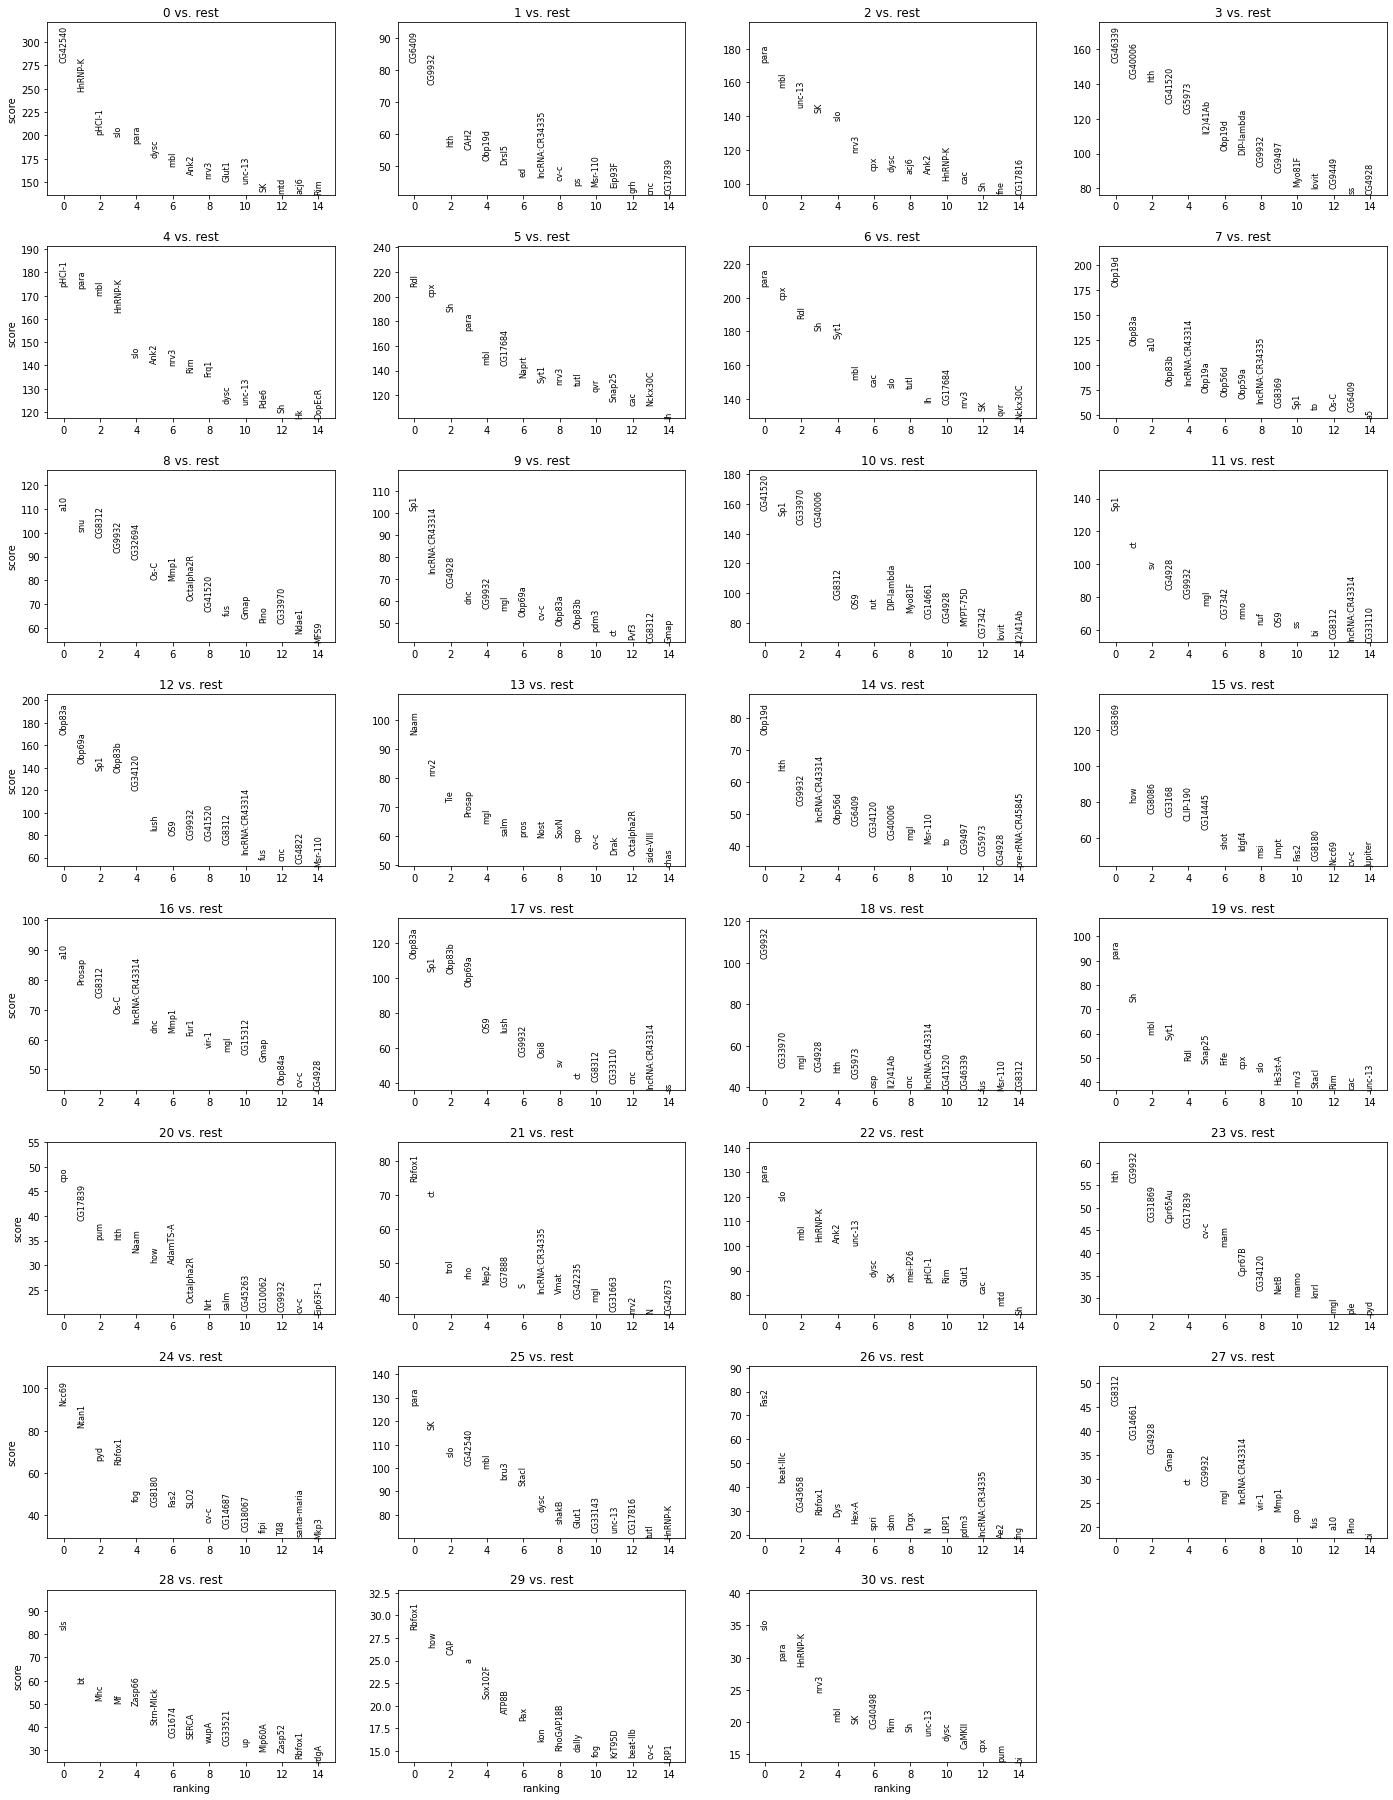

In [ ]:
# Ranks the marker genes of leiden groups
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# Plots the most differantiating marker genes for clusters
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [ ]:
# Prints the clusters and their most 10 important marker genes
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,CG42540,CG6409,para,CG46339,pHCl-1,Rdl,para,Obp19d,a10,Sp1,CG41520,Sp1,Obp83a,Naam,Obp19d,CG8369,a10,Obp83a,CG9932,para,cpo,Rbfox1,para,hth,Ncc69,para,Fas2,CG8312,sls,Rbfox1,slo
1,HnRNP-K,CG9932,mbl,CG40006,para,cpx,cpx,Obp83a,snu,lncRNA:CR43314,Sp1,ct,Obp69a,nrv2,hth,how,Prosap,Sp1,CG33970,Sh,CG17839,ct,slo,CG9932,Ntan1,SK,beat-IIIc,CG14661,bt,how,para
2,pHCl-1,hth,unc-13,hth,mbl,Sh,Rdl,a10,CG8312,CG4928,CG33970,sv,Sp1,Tie,CG9932,CG8086,CG8312,Obp83b,mgl,mbl,pum,trol,mbl,CG31869,pyd,slo,CG43658,CG4928,Mhc,CAP,HnRNP-K
3,slo,CAH2,SK,CG41520,HnRNP-K,para,Sh,Obp83b,CG9932,dnc,CG40006,CG4928,Obp83b,Prosap,lncRNA:CR43314,CG3168,Os-C,Obp69a,CG4928,Syt1,hth,rho,HnRNP-K,Cpr65Au,Rbfox1,CG42540,Rbfox1,Gmap,Mf,a,nrv3
4,para,Obp19d,slo,CG5973,slo,mbl,Syt1,lncRNA:CR43314,CG32694,CG9932,CG8312,CG9932,CG34120,mgl,Obp56d,CLIP-190,lncRNA:CR43314,OS9,hth,Rdl,Naam,Nep2,Ank2,CG17839,fog,mbl,Dys,ct,Zasp66,Sox102F,mbl
5,dysc,Drsl5,nrv3,l(2)41Ab,Ank2,CG17684,mbl,Obp19a,Os-C,mgl,OS9,mgl,lush,salm,CG6409,CG14445,dnc,lush,CG5973,Snap25,how,CG7888,unc-13,cv-c,CG8180,bru3,Hex-A,CG9932,Strn-Mlck,ATP8B,SK
6,mbl,ed,cpx,Obp19d,nrv3,Naprt,cac,Obp56d,Mmp1,Obp69a,rut,CG7342,OS9,pros,CG34120,shot,Mmp1,CG9932,osp,Fife,AdamTS-A,S,dysc,mam,Fas2,Stacl,spri,mgl,CG1674,Pax,CG40498
7,Ank2,lncRNA:CR34335,dysc,DIP-lambda,Rim,Syt1,slo,Obp59a,Octalpha2R,cv-c,DIP-lambda,nmo,CG9932,Nost,CG40006,Idgf4,Fur1,Osi8,l(2)41Ab,cpx,Octalpha2R,lncRNA:CR34335,SK,Cpr67B,SLO2,dysc,sbm,lncRNA:CR43314,SERCA,kon,Rim
8,nrv3,cv-c,acj6,CG9932,Frq1,nrv3,tutl,lncRNA:CR34335,CG41520,Obp83a,Myo81F,nuf,CG41520,SoxN,mgl,msi,vir-1,sv,cnc,slo,Nrt,Vmat,mei-P26,CG34120,cv-c,shakB,Drgx,vir-1,wupA,RhoGAP18B,Sh
9,Glut1,ps,Ank2,CG9497,dysc,tutl,Ih,CG8369,fus,Obp83b,CG14661,OS9,CG8312,cpo,Msr-110,Lmpt,mgl,ct,lncRNA:CR43314,Hs3st-A,salm,CG42235,pHCl-1,NetB,CG14687,Glut1,N,Mmp1,CG33521,dally,unc-13


In [ ]:
# Creates cluster names by their number
cluster_names = []
for i in range(31):
  clust = 'cluster ' + str(i)
  cluster_names.append(clust)

# Creates a dataframe from ranked genes by cutting off last 10000 genes
n = 10000
df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
df.columns = cluster_names
df.drop(df.tail(n).index,inplace=True)

# Creates dictionary of the target genes and clusters ({or_gene: {cluster1: count, cluster2: count2}})
list_diff_exp = ['Or47a', 'Or43b', 'Or33c', 'Or47b',  'Or85a', 'Or71a', 'Or9a', 'Or59b', 'Or67a', 'Or82a']

dict_diff_exp = dict.fromkeys(list_diff_exp, {})
for d, v in dict_diff_exp.items():
  clusters = dict.fromkeys(cluster_names, 0)
  dict_diff_exp[d] = clusters

for cluster_name in cluster_names:
  for i in range(len(df)):
    current_gene = df[cluster_name][i]
    if current_gene in dict_diff_exp.keys():
      dict_diff_exp[current_gene][cluster_name] += 1
print('Or genes in the clusters:')
print(dict_diff_exp)

Or genes in the clusters:
{'Or47a': {'cluster 0': 1, 'cluster 1': 0, 'cluster 2': 0, 'cluster 3': 0, 'cluster 4': 1, 'cluster 5': 0, 'cluster 6': 0, 'cluster 7': 1, 'cluster 8': 0, 'cluster 9': 0, 'cluster 10': 0, 'cluster 11': 0, 'cluster 12': 0, 'cluster 13': 0, 'cluster 14': 0, 'cluster 15': 0, 'cluster 16': 0, 'cluster 17': 0, 'cluster 18': 0, 'cluster 19': 0, 'cluster 20': 0, 'cluster 21': 0, 'cluster 22': 0, 'cluster 23': 0, 'cluster 24': 0, 'cluster 25': 0, 'cluster 26': 1, 'cluster 27': 0, 'cluster 28': 0, 'cluster 29': 1, 'cluster 30': 1}, 'Or43b': {'cluster 0': 1, 'cluster 1': 0, 'cluster 2': 0, 'cluster 3': 0, 'cluster 4': 1, 'cluster 5': 0, 'cluster 6': 0, 'cluster 7': 1, 'cluster 8': 0, 'cluster 9': 0, 'cluster 10': 0, 'cluster 11': 0, 'cluster 12': 0, 'cluster 13': 0, 'cluster 14': 0, 'cluster 15': 0, 'cluster 16': 0, 'cluster 17': 0, 'cluster 18': 0, 'cluster 19': 0, 'cluster 20': 0, 'cluster 21': 0, 'cluster 22': 1, 'cluster 23': 0, 'cluster 24': 0, 'cluster 25': 0, 'cl

In [ ]:
# Finds the counts of cell types in the created leiden clusters 

df1 = adata.obs.loc[:,['annotation','leiden']]
df1.index = df1['leiden']
df1 = df1.drop(columns=['leiden'])

clusterList = list(map(str,sorted(list(map(int,list(df1.index.unique()))))))
clusterList

annotationList = sorted(list(df1.annotation.unique()))

cdf = pd.DataFrame(0, columns=clusterList, index=annotationList)

for m in range(len(clusterList)):
  cluster_name = clusterList[m]
  for n in range(len(annotationList)):
    cellType = annotationList[n]
    count = 0
    types_in_cluster = list(df1.loc[cluster_name]['annotation'])
    for i in range(len(types_in_cluster)):
      if types_in_cluster[i] == cellType:
        count = count + 1
        cdf.loc[cellType, cluster_name] = count
cdf.columns = ['Cluster ' + s for s in clusterList]
cdf.to_csv('clusterGenes.csv')
cdf

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14,Cluster 15,Cluster 16,Cluster 17,Cluster 18,Cluster 19,Cluster 20,Cluster 21,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27,Cluster 28,Cluster 29,Cluster 30
Johnston organ neuron,1,0,2,0,5,2066,1695,7,0,0,0,0,0,0,3,1,1,0,0,4,0,0,26,1,0,0,0,0,0,0,0
adult antenna glial cell,47,40,11,23,8,2,4,62,33,8,17,12,11,5,8,835,3,5,11,0,0,492,10,4,408,0,280,0,0,1,0
adult olfactory receptor neuron Gr21a/63a,9,0,12,0,20,0,33,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,362,0,0,0,0,0
"adult olfactory receptor neuron Ir56a+, Orco-",13,2,205,0,4,1,8,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7,0,0,0,0,0,0,0,0
adult olfactory receptor neuron Ir75d,12,0,566,0,32,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0
"adult olfactory receptor neuron Ir84a, Ir31a, Ir76a, Ir76b, Ir8a, Or35a",15,0,266,0,8,0,0,9,0,0,0,0,0,0,0,0,0,1,0,4,0,0,2,0,0,0,0,0,0,0,0
adult olfactory receptor neuron Or13a,64,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
"adult olfactory receptor neuron Or22a, Or42b, Or59b",649,0,0,0,16,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0
"adult olfactory receptor neuron Or47a, Or56a and likely other ORN types",554,0,2,0,43,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
adult olfactory receptor neuron Or47b,8,0,0,0,422,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0
